# Śledzenie rozgyrwki bilarda

## Import niezbędnych bibliotek

In [1]:
%matplotlib inline
import numpy as np
import cv2

from ipywidgets import Video

import PIL
from IPython.display import display

def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

## Analiza wideo

### Wczytanie wideo i jego podstawowych właściwości

In [2]:
video = cv2.VideoCapture('data/9-ball/video6.mov')
if video.isOpened():
    print('Movie loaded :)')

width = int(video.get(3))
height = int(video.get(4))
print(f'Wysokość i szerokość obrazu: {height} x {width}')

fps = video.get(cv2.CAP_PROP_FPS)
print(f'Liczba klatek na sekundę: {fps}')

Movie loaded :)
Wysokość i szerokość obrazu: 1054 x 1924
Liczba klatek na sekundę: 59.891696750902526


### Wyświetlenie analizowanego wideo

In [3]:
Video.from_file('data/9-ball/video1.mov')

Video(value=b'\x00\x00\x00\x14ftypqt  \x00\x00\x00\x00qt  \x00\x00\x00\x08wide\x01\x02\xee\xc3mdat\x00\x01\x03…

### Poszukiwanie współrzędnych bil na filmie

### Wykorzystanie algorytmu CSRT do śledzenia znalezionych bili na filmie

In [4]:
def create_tracker(tracker_type):
  tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

  if tracker_type == 'BOOSTING':
      return cv2.legacy.TrackerBoosting_create()
  if tracker_type == 'MIL':
      return cv2.legacy.TrackerMIL_create()
  if tracker_type == 'KCF':
      return cv2.legacy.TrackerKCF_create()
  if tracker_type == 'TLD':
      return cv2.legacy.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      return cv2.legacy.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      return cv2.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      return cv2.legacy.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      return cv2.TrackerCSRT_create()


In [38]:
def draw_bbox(frame, bbox, color=(255, 255, 255)):

    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)

def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def circle_to_rectangle(circle, radius):
    return (int(circle[0]-radius), int(circle[1]-radius), int(2*radius),  int(2*radius))

def crop_circle(frame, circle):
    bbox = circle_to_rectangle(circle, circle[2])
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    return frame[p1[1]:p2[1], p1[0]:p2[0]]


def calculate_velocity(x, y, fps, n_frames):
  return np.sqrt(x**2 + y**2)/(n_frames/fps)

def collision(c1, c2, v1p, v1, v2p, v2, min_deg_tol, max_pos_tol, fps, n_frames):

    v1_val = calculate_velocity(v1[0], v1[1], fps, n_frames)
    v2_val = calculate_velocity(v2[0], v2[1], fps, n_frames)
    v1p_val = calculate_velocity(v1p[0], v1p[1], fps, n_frames)
    v2p_val = calculate_velocity(v2p[0], v2p[1], fps, n_frames)

    dp = v1[0] * v2[0] + v1[1] + v2[1]

    if distance(c1, c2) < max_pos_tol and dp > 0:

        return True
        # dp1 = v1[0] * v1p[0] + v1[1] + v1p[1]
        # den1 = v1_val * v1p_val

        # dp2 = v2[0] * v2p[0] + v2[1] + v2p[1]
        # den2 = v2_val * v2p_val
        # if dp1 / den1 < np.cos(min_deg_tol) or dp2 / den2 < np.cos(min_deg_tol):
        #     return True

    return False

def count_centroid(b):
    return [ int(b[0] + b[2]/2), int(b[1] + b[3]/2) ]

def find_circles(frame, max_r, min_r):

    filter = np.array([
        [-1, -1, -1], 
        [-1, 9, -1], 
        [-1, -1, -1]
    ]) 

    sharpen_img_1 = cv2.filter2D(frame, -1, filter)
    cimg = cv2.cvtColor(sharpen_img_1, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT, 1, 2 * min_r, param1 = 60, 
                param2 = 20, minRadius = min_r, maxRadius = max_r)
    
    circles = np.uint16(np.around(circles))
    
    return circles

def draw_points(frame, points, radius, thickness):

    for p in points:
        cv2.circle(frame, p, radius, (0, 0, 0), thickness)

def find_pocket(frame):

    filter = np.array([
        [-1, -1, -1], 
        [-1, 9, -1], 
        [-1, -1, -1]
    ]) 
    
    sharpen_img_1 = cv2.filter2D(frame, -1, filter)
    cimg = cv2.cvtColor(sharpen_img_1, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(cimg,7)
    circles_blur = cv2.HoughCircles(blur,cv2.HOUGH_GRADIENT,1,frame.shape[0]/3,
                            param1=60,param2=20,minRadius=35,maxRadius=50)
    pockets = np.uint16(np.around(circles_blur))

    # for i in pockets[0,:]:
    #     # draw the outer circle
    #     cv2.circle(frame,(i[0],i[1]),i[2],(0,255,0),2)

    return pockets

def in_pocket(bill_pos, pocket_pos, pocket_r, bill_r):

    dist = distance(bill_pos.astype(np.float32), pocket_pos.astype(np.float32))
    if dist < pocket_r:
        return True
    
    return False

boundaries = {
    'white' : [[0,0,245], [179,104,255]],
    'yellow' : [[13,60,96], [51,255,255]],
    'blue' : [[108,48,80], [131,255,218]],
    'green' : [[34,68,75], [99,255,183]],
    'pink' : [[153,160,0], [173,255,255]],
    'purple' : [[119,48,71], [157,215,229]],
    'brown' : [[0,168,0], [16,255,168]],
    'red' : [[148,196,0], [179,255,255]],
    'black' : [[0,0,0], [179,255,85]]
}

def color_percentage(frame, lower, upper):
    
    grid_RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    grid_HSV = cv2.cvtColor(grid_RGB, cv2.COLOR_RGB2HSV) 
    mask= cv2.inRange(grid_HSV, np.array(lower), np.array(upper))
    
    return (mask>0).mean()*100

def keywithmaxval(d):
     
     v = list(d.values())
     k = list(d.keys())
     maximum = (max(v))
     return  (k[v.index(maximum)],maximum)

def find_colours(frame, max_r, min_r):

    filter = np.array([
        [-1, -1, -1], 
        [-1, 9, -1], 
        [-1, -1, -1]
    ]) 

    sharpen_img_1 = cv2.filter2D(frame, -1, filter)
    cimg = cv2.cvtColor(sharpen_img_1, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT, 1, 2 * min_r, param1 = 60, 
                param2 = 20, minRadius = min_r, maxRadius = max_r)
    
    circles = np.uint16(np.around(circles))
    not_bills = []
    bill_colours = []

    for idx, i in enumerate(circles[0,:]):
        cropped = crop_circle(frame, i)
        # imshow(cropped)
        colours = {
            'white' : 0.0,
            'yellow' : 0.0,
            'blue' : 0.0,
            'green' : 0.0,
            'pink' : 0.0,
            'purple' : 0.0,
            'brown' : 0.0,
            'red' : 0.0,
            'black' : 0.0,
        }
        bill = False
        for key, value in boundaries.items():
            percentage = color_percentage(cropped, value[0], value[1])
            # print(f'{key}: {percentage}')
            colours[key] = percentage
        k, v = keywithmaxval(colours)
        if (v > 30):
            if k == 'black' or k == 'yellow':
                if (colours['black'] > 30) and colours['yellow'] > 10:
                    # print('black_yellow')
                    bill_colours.append('black_yellow')
                    bill = True
                else:
                    # print(f'{k}')
                    bill_colours.append(k)
                    bill = True
            else:
                # print(f'{k}')
                bill_colours.append(k)
                bill = True
        if bill == False:
            not_bills.append(idx)
            print("NOTBILL")


    circles = np.delete(circles[0], not_bills, axis=0)[np.newaxis]

    for idx, i in enumerate(circles[0,:]):
        cv2.circle(frame, (i[0], i[1]), i[2], (0,255,0), 2)
    
    return circles, bill_colours

In [54]:
video = cv2.VideoCapture('data/9-ball/video4.mov')
if video.isOpened():
    print('Movie loaded :)')

width = int(video.get(3))
height = int(video.get(4))

fps = video.get(cv2.CAP_PROP_FPS)
print(f'Liczba klatek na sekundę: {fps}')


Movie loaded :)
Liczba klatek na sekundę: 57.634408602150536


white
0
green
6
black
8
red
3
yellow
1
pink
5
black_yellow
9
blue
2
brown
7
4


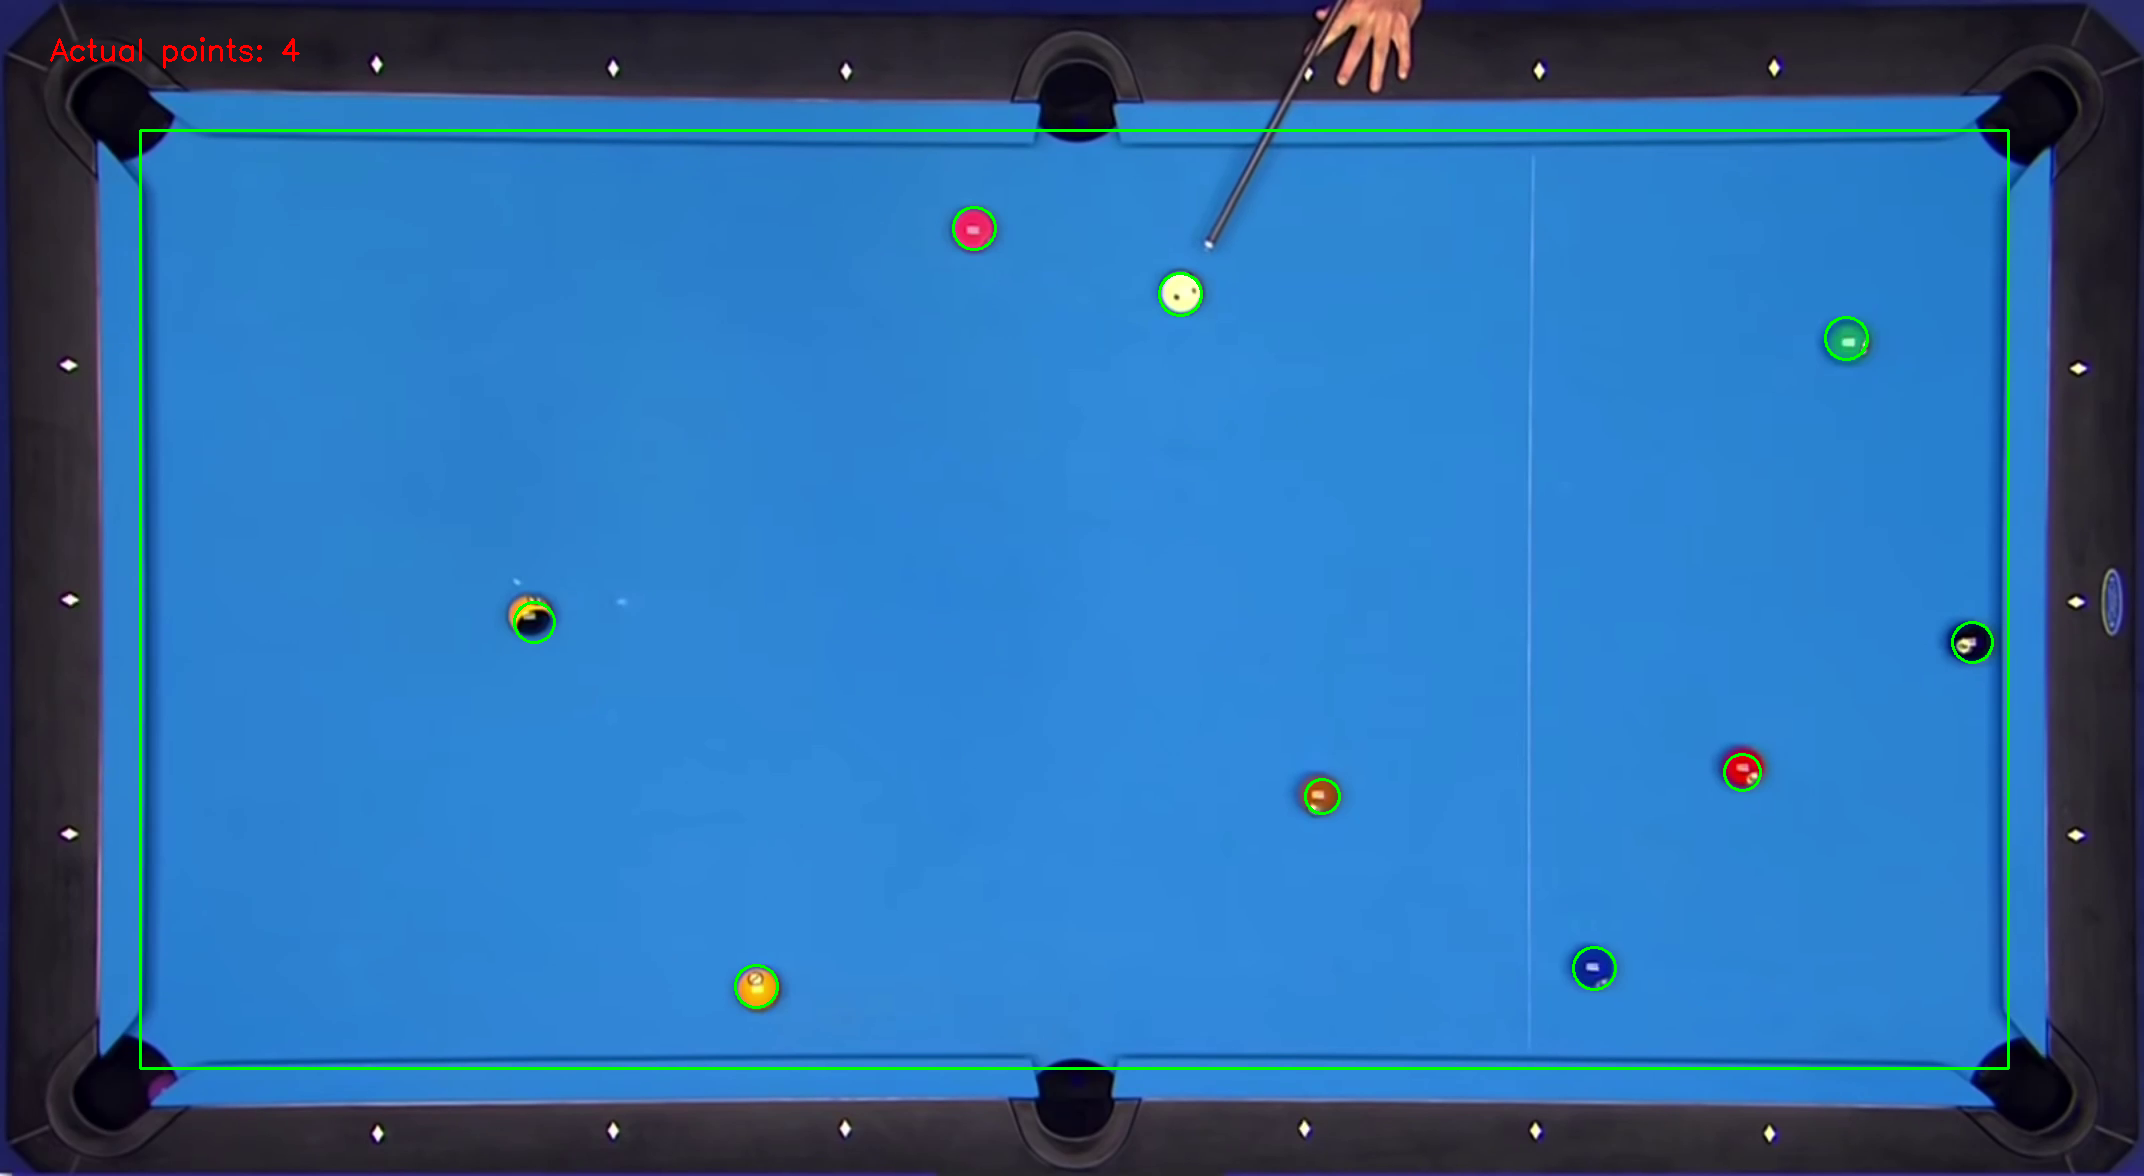

In [60]:
points = {
            'white' : 0,
            'yellow' : 1,
            'blue' : 2,
            'red' : 3,
            'purple' : 4,
            'pink' : 5,
            'green' : 6,
            'brown' : 7,
            'black' : 8,
            'black_yellow' : 9,
        }

ret, frame = video.read()

pockets = find_pocket(frame)
# print(pockets)

p1 = (np.min(pockets[0], axis=0)[0]+30, np.min(pockets[0], axis=0)[1]+30)
p2 = (np.max(pockets[0], axis=0)[0]-30, np.max(pockets[0], axis=0)[1]-30)

cv2.rectangle(frame, p1, p2, (0,255,0), 2, 1)

bills, bill_colours = find_colours(frame,22,14)

# print(bills)

GAME_POINTS = 45
for idx, b in enumerate(bills[0,:]):
    if b[0] > p1[0] and b[0] < p2[0] and b[1] > p1[1] and b[1] < p2[1]:
        print(bill_colours[idx])
        print(points[bill_colours[idx]])
        GAME_POINTS = GAME_POINTS - points[bill_colours[idx]]
print(GAME_POINTS)

cv2.putText(frame, f'Actual points: {GAME_POINTS}', (50,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)


# draw_points(frame, pockets[0, :, :2], 10, -1)

imshow(frame)

In [57]:
# import cv2
# import numpy as np

# def nothing(x):
#     pass

# # Load image
# image = frame

# # Create a window
# cv2.namedWindow('image')

# # Create trackbars for color change
# # Hue is from 0-179 for Opencv
# cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
# cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
# cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
# cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
# cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
# cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# # Set default value for Max HSV trackbars
# cv2.setTrackbarPos('HMax', 'image', 179)
# cv2.setTrackbarPos('SMax', 'image', 255)
# cv2.setTrackbarPos('VMax', 'image', 255)

# # Initialize HSV min/max values
# hMin = sMin = vMin = hMax = sMax = vMax = 0
# phMin = psMin = pvMin = phMax = psMax = pvMax = 0

# while(1):
#     # Get current positions of all trackbars
#     hMin = cv2.getTrackbarPos('HMin', 'image')
#     sMin = cv2.getTrackbarPos('SMin', 'image')
#     vMin = cv2.getTrackbarPos('VMin', 'image')
#     hMax = cv2.getTrackbarPos('HMax', 'image')
#     sMax = cv2.getTrackbarPos('SMax', 'image')
#     vMax = cv2.getTrackbarPos('VMax', 'image')

#     # Set minimum and maximum HSV values to display
#     lower = np.array([hMin, sMin, vMin])
#     upper = np.array([hMax, sMax, vMax])

#     # Convert to HSV format and color threshold
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv, lower, upper)
#     result = cv2.bitwise_and(image, image, mask=mask)

#     # Print if there is a change in HSV value
#     if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
#         print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
#         phMin = hMin
#         psMin = sMin
#         pvMin = vMin
#         phMax = hMax
#         psMax = sMax
#         pvMax = vMax

#     # Display result image
#     cv2.imshow('image', result)
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()

In [9]:
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = video.read()

HISTORY = 5
MOV_TOLERANCE = 3
MAX_POS_TOL = None
MIN_DEG_TOL = np.pi/6

ANALYZE_FROM = 0
ANALYZE_TO = np.inf

video.set(1, ANALYZE_FROM)
ret, frame = video.read()

circles = find_circles(frame, 21, 13)
# circles = find_colours(frame, 21, 13)
avg_r = np.average(circles[0, :, 2])

bills = []

for c in circles[0]:
    bills.append(create_tracker('CSRT'))
    bills[-1].init(frame, circle_to_rectangle(c, avg_r + 10))

MAX_POS_TOL = 3.5 * avg_r

video_tracker = cv2.VideoWriter('video_tracker_4.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))



frames_number = 0

collisions = []
last_frames_pos = np.zeros((HISTORY,len(bills),  2), dtype=np.int32)
last_frames_v = np.zeros((HISTORY, len(bills),  2), dtype=np.int32)

pos = np.zeros((len(bills), 2), dtype=np.int32)
vel = np.zeros((len(bills),2 ), dtype=np.int32)

for idx, b in enumerate(bills):
    _, bbox = b.update(frame)
    pos[idx] = count_centroid(bbox)

last_frames_pos = last_frames_pos + pos

while video.isOpened():

    frames_number += 1
    ret, frame = video.read()
    
    if ret and frames_number < ANALYZE_TO - ANALYZE_FROM:

        bbox = None
        for idx, b in enumerate(bills):
            ok, bbox = b.update(frame)
            if ok: draw_bbox(frame, bbox, (0, 255, 0))

            pos[idx] = count_centroid(bbox)

        for idx, b in enumerate(bills):
            dist = distance(pos[idx], last_frames_pos[0][idx])
            if dist > MOV_TOLERANCE:
                
                vel[idx] = np.array([
                    pos[idx][0] - last_frames_pos[0][idx][0], pos[idx][1] - last_frames_pos[0][idx][1]
                ]) / (HISTORY/fps)
            else:
                vel[idx] = np.array([0,0])

            # if you want to draw velocities vectors
            # cv2.line(frame, pos[idx], (pos[idx] + np.average(last_frames_v[:, idx], axis=0)/6).astype(np.int32), (255, 0, 0), thickness=2)

        last_frames_pos = np.concatenate([last_frames_pos, [pos.copy()]], axis=0)
        last_frames_v = np.concatenate([last_frames_v, [vel.copy()]], axis=0)

        last_frames_pos = np.delete(last_frames_pos, 0, axis=0)
        last_frames_v = np.delete(last_frames_v, 0, axis=0)

        bill_pos = last_frames_pos[-1][0]
        bill_v = last_frames_v[-1][0]


        for i in range(len(bills) - 1):
            for j in range(i + 1, len(bills)):

                b1 = pos[i]
                b2 = pos[j]
                v1 = vel[i]
                v2 = vel[j]
                v1p = last_frames_v[0][i]
                v2p = last_frames_v[0][j]

                if collision(b1, b2, v1p, v1, v2p, v2, MIN_DEG_TOL, MAX_POS_TOL, fps, HISTORY):
                    collisions.append([
                        frames_number, 
                    ])
                    for k in range(20):
                
                        cv2.putText(frame, 'COLLISION', b1 + 40, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        video_tracker.write(frame)

        video_tracker.write(frame)
    else:
        break

video_tracker.release()

KeyboardInterrupt: 

In [ ]:
!ffmpeg -hide_banner -loglevel error -i video_tracker_4.avi -y video_tracker_4.mp4

In [ ]:
Video.from_file('video_tracker_4.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0b\xe5Vmdat\x00\x…

In [43]:
video = cv2.VideoCapture('movies/video1.mov')
if video.isOpened():
    print('Movie loaded :)')

width = int(video.get(3))
height = int(video.get(4))

fps = video.get(cv2.CAP_PROP_FPS)
print(f'Liczba klatek na sekundę: {fps}')

Movie loaded :)
Liczba klatek na sekundę: 59.21052631578947


In [61]:
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = video.read()

HISTORY = 5
MOV_TOLERANCE = 3
MAX_POS_TOL = None
MIN_DEG_TOL = np.pi/6

ANALYZE_FROM = 0
ANALYZE_TO = 400

video.set(1, ANALYZE_FROM)
ret, frame = video.read()

# circles = find_circles(frame, 21, 13)


circles, bill_colours = find_colours(frame, 21, 13)

avg_r = np.average(circles[0, :, 2])

pockets = find_pocket(frame)
avg_pr = np.average(pockets[0, :, 2])

print(pockets)

p1 = (np.min(pockets[0], axis=0)[0]+30, np.min(pockets[0], axis=0)[1]+30)
p2 = (np.max(pockets[0], axis=0)[0]-30, np.max(pockets[0], axis=0)[1]-30)

cv2.rectangle(frame, p1, p2, (0,255,0), 2, 1)

GAME_POINTS = 45
for idx, b in enumerate(circles[0,:]):
    if b[0] > p1[0] and b[0] < p2[0] and b[1] > p1[1] and b[1] < p2[1]:
        print(bill_colours[idx])
        print(points[bill_colours[idx]])
        GAME_POINTS = GAME_POINTS - points[bill_colours[idx]]
print(GAME_POINTS)

cv2.putText(frame, f'Actual points: {GAME_POINTS}', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

bill_in_pocket = [0] * circles.shape[1]

bills = []

for i, c in enumerate(circles[0]):
    bills.append(create_tracker('CSRT'))
    bills[-1].init(frame, circle_to_rectangle(c, avg_r + 10))

    for p in pockets[0]:
        if in_pocket(c[:2], p[:2], p[2] + 40, c[2]):
            bill_in_pocket[i] = 1

print(bill_in_pocket)

MAX_POS_TOL = 3.5 * avg_r

video_tracker = cv2.VideoWriter('video_tracker.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))



frames_number = 0

collisions = []
last_frames_pos = np.zeros((HISTORY,len(bills),  2), dtype=np.int32)
last_frames_v = np.zeros((HISTORY, len(bills),  2), dtype=np.int32)

pos = np.zeros((len(bills), 2), dtype=np.int32)
vel = np.zeros((len(bills),2 ), dtype=np.int32)

for idx, b in enumerate(bills):
    _, bbox = b.update(frame)
    pos[idx] = count_centroid(bbox)

last_frames_pos = last_frames_pos + pos

while video.isOpened():

    frames_number += 1
    ret, frame = video.read()
    cv2.putText(frame, f'Actual points: {GAME_POINTS}', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    draw_points(frame, pockets[0, :, :2], int(avg_pr), thickness=4)

    if ret and frames_number < ANALYZE_TO - ANALYZE_FROM:

        bbox = None
        for idx, b in enumerate(bills):
            ok, bbox = b.update(frame)
            if ok: draw_bbox(frame, bbox, (0, 255, 0))

            pos[idx] = count_centroid(bbox)

        for idx, b in enumerate(bills):
            dist = distance(pos[idx], last_frames_pos[0][idx])
            if dist > MOV_TOLERANCE:
                
                vel[idx] = np.array([
                    pos[idx][0] - last_frames_pos[0][idx][0], pos[idx][1] - last_frames_pos[0][idx][1]
                ]) / (HISTORY/fps)
            else:
                vel[idx] = np.array([0,0])

            for p in pockets[0]:
                if in_pocket(pos[idx], p[:2], p[2] + 40, None) and bill_in_pocket[idx] == 0:
                    bill_in_pocket[idx] = 1
                    print(1)
                    GAME_POINTS += points[bill_colours[idx]]
                    for k in range(20):
                        cv2.putText(frame, f'SCORES +{points[bill_colours[idx]]}', pos[idx] + 40, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        video_tracker.write(frame)
                    

        last_frames_pos = np.concatenate([last_frames_pos, [pos.copy()]], axis=0)
        last_frames_v = np.concatenate([last_frames_v, [vel.copy()]], axis=0)

        last_frames_pos = np.delete(last_frames_pos, 0, axis=0)
        last_frames_v = np.delete(last_frames_v, 0, axis=0)

        bill_pos = last_frames_pos[-1][0]
        bill_v = last_frames_v[-1][0]



        video_tracker.write(frame)
    else:
        break

video_tracker.release()

[[[1078  102   40]
  [1074 1098   40]
  [ 110  106   39]
  [ 112 1090   39]
  [2038  110   39]
  [2030 1088   42]]]
pink
5
red
3
black
8
white
0
green
6
black_yellow
9
yellow
1
brown
7
blue
2
4
[0, 0, 0, 0, 0, 0, 0, 0, 0]


In [62]:
!ffmpeg -hide_banner -loglevel error -i video_tracker.avi -y video_tracker.mp4
Video.from_file('video_tracker.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0b\xd0\xbamdat\x0…